## Non-Relativistic Particle-in-cell simulator [NRPIC_UPV]
##### Marco Nieto

In [263]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from mpl_toolkits import mplot3d
import random as rd

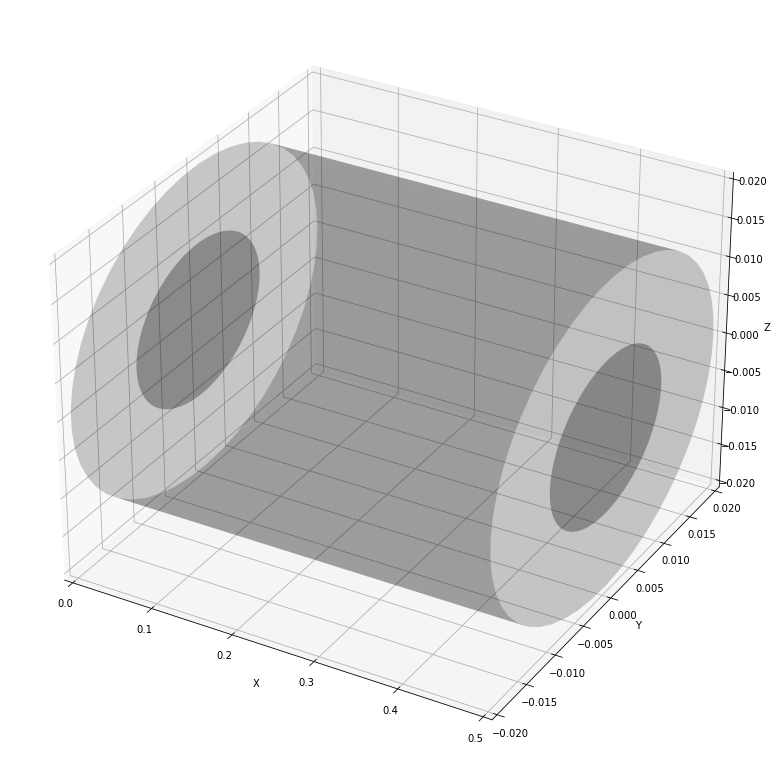

In [264]:

R = 2*10**-2
L = 5*10**-1
IR = 10**-2
OR =10**-2


def data_for_cylinder_along_x():
    x = np.linspace(0, L, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, x_grid = np.meshgrid(theta, x)
    y_grid = R * np.cos(theta_grid) 
    z_grid = R * np.sin(theta_grid) 
    return x_grid, y_grid, z_grid

fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(111, projection='3d')

Xc, Yc, Zc = data_for_cylinder_along_x()
ax.plot_surface(Xc, Yc, Zc, color='k', alpha=0.2 )

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(0, L)
ax.set_ylim(-R, R)
ax.set_zlim(-R, R)



inlet = Circle((0, 0), IR)
inlet.set_facecolor('k') 
inlet.set_alpha(0.3)
ax.add_patch(inlet)
art3d.pathpatch_2d_to_3d(inlet, z=0, zdir="x")

outlet = Circle((0, 0), OR)
outlet.set_facecolor('k') 
outlet.set_alpha(0.3)
ax.add_patch(outlet)
art3d.pathpatch_2d_to_3d(outlet, z=L, zdir="x")




plt.show()

#### Beam specifications (meters)
- Charge (q) $[\pm 1,0]$
- Particles (N)
- Energy of each particle (eV)
- Particle mass

We assume that the particle is non-relativistic, therefore its initial velocity is defined, given by the expression:

$$ |\vec{\textbf{v}}| = \sqrt{\frac{2 e} {m}} \pm k$$

Being $k$ a perturbation, sum of the three deviations of each velocity component $v_i$ from the central value with a $\kappa$% factor.

An additional restriction for a maximum dispersion angle $\alpha$ has to be taken in account. The model generates for each particle two initial values of $\phi$ and $\theta$ such that $\phi \in [-\frac{\alpha}{2}, \frac{\alpha}{2}]$ and $\theta \in [\frac{\pi}{2}-\frac{\alpha}{2}, \frac{\pi}{2}+\frac{\alpha}{2}]$. Velocity components can be obtained as:

$$ v_x= |\vec{\textbf{v}}| \sin(\theta)\cos(\phi) $$
$$ v_y= |\vec{\textbf{v}}| \sin(\theta)\sin(\phi)$$
$$ v_z= |\vec{\textbf{v}}| \cos(\theta) $$

In [265]:

a = 1
b=1
L = 5

c=0.5 
d=0.5

alpha = 3*np.pi/4
kappa = 2

E = 14.1 
mass = 1

N = 400   # Number of particles
m = 40     # Number of mesh cells x axis
n = 20     # Number of mesh cells y axis
o = 20     # Number of mesh cells z axis

t         = 0       # current time of the simulation (us)
tEnd      = 50      # time at which simulation ends (us)
dt        = 1       # timestep (us)



def getAcc( pos, Nx, boxsize, n0, Gmtx, Lmtx ):
	"""
    Calculate the acceleration on each particle due to electric field
	pos      is an Nx1 matrix of particle positions
	Nx       is the number of mesh cells
	boxsize  is the domain [0,boxsize]
	n0       is the electron number density
	Gmtx     is an Nx x Nx matrix for calculating the gradient on the grid
	Lmtx     is an Nx x Nx matrix for calculating the laplacian on the grid
	a        is an Nx1 matrix of accelerations
	"""
	# Calculate Electron Number Density on the Mesh by 
	# placing particles into the 2 nearest bins (j & j+1, with proper weights)
	# and normalizing
	N          = pos.shape[0]
	dx         = boxsize / Nx
	j          = np.floor(pos/dx).astype(int)
	jp1        = j+1
	weight_j   = ( jp1*dx - pos  )/dx
	weight_jp1 = ( pos    - j*dx )/dx
	jp1        = np.mod(jp1, Nx)   # periodic BC
	n  = np.bincount(j[:,0],   weights=weight_j[:,0],   minlength=Nx);
	n += np.bincount(jp1[:,0], weights=weight_jp1[:,0], minlength=Nx);
	n *= n0 * boxsize / N / dx 
	
	# Solve Poisson's Equation: laplacian(phi) = n-n0
	phi_grid = spsolve(Lmtx, n-n0, permc_spec="MMD_AT_PLUS_A")
	
	# Apply Derivative to get the Electric field
	E_grid = - Gmtx @ phi_grid
	
	# Interpolate grid value onto particle locations
	E = weight_j * E_grid[j] + weight_jp1 * E_grid[jp1]
	
	a = -E

	return a
	
#initial conditions----------------------------------------------------------
x = np.zeros(N)
y = np.random.uniform(a/2 - c/2, a/2 +c/2, N)
z = np.random.uniform(b/2 - d/2, b/2 +d/2, N)
vx = np.zeros(N)
vy = np.zeros(N)
vz = np.zeros(N)
modv = np.sqrt(2*E/m)
for i in range(N):
	theta = np.random.uniform(np.pi/2 - alpha/2 ,np.pi/2 + alpha/2, 1)[0]
	phi = np.random.uniform(-alpha/2 ,alpha/2, 1)[0]
	vx[i]= modv * np.cos(phi)*np.sin(theta) + ((rd.random()*2)-1)*(modv * np.cos(phi)*np.sin(theta))*(kappa/100)
	vy[i]= modv * np.sin(phi)*np.sin(theta) + ((rd.random()*2)-1)*(modv * np.sin(phi)*np.sin(theta))*(kappa/100)
	vz[i]= modv * np.cos(theta) + ((rd.random()*2)-1)*(modv * np.cos(theta))*(kappa/100)
#----------------------------------------------------------------------------


def linear_scattering(x,y,z,m,n,o,a,b,L,N):
	hx = L/m 
	hy = a/n
	hz = b/o
	mesh = np.zeros((m+1,n+1,o+1))

	for i in range(N):
		xgreater = False
		ygreater = False
		zgreater = False
		xsteps = 0
		ysteps = 0
		zsteps = 0
		while xgreater == False:
			if x[i]<hx*xsteps:
				xgreater = True
			else:
				xsteps += 1
		while ygreater == False:
			if y[i]<hy*ysteps:
				ygreater = True	
			else:
				ysteps += 1
		while zgreater == False:
			if z[i]<hz*zsteps:
				zgreater = True	
			else:
				zsteps += 1
		
	
		weight_nextx = (1-(hx*xsteps-x[i])/hx)
		weight_prevx = 1-weight_nextx
		weight_nexty = (1-(hy*ysteps-y[i])/hy)
		weight_prevy = 1-weight_nexty
		weight_nextz = (1-(hz*zsteps-z[i])/hz)
		weight_prevz = 1-weight_nextz

		mesh[xsteps-1][ysteps-1][zsteps-1] += weight_prevx*weight_prevy*weight_prevz
		mesh[xsteps-1][ysteps-1][zsteps] += weight_prevx*weight_prevy*weight_nextz
		mesh[xsteps-1][ysteps][zsteps-1] += weight_prevx*weight_nexty*weight_prevz
		mesh[xsteps-1][ysteps][zsteps] += weight_prevx*weight_nexty*weight_nextz
		mesh[xsteps][ysteps-1][zsteps-1] += weight_nextx*weight_prevy*weight_prevz
		mesh[xsteps][ysteps-1][zsteps] += weight_nextx*weight_prevy*weight_nextz
		mesh[xsteps][ysteps][zsteps-1] += weight_nextx*weight_nexty*weight_prevz
		mesh[xsteps][ysteps][zsteps] += weight_nextx*weight_nexty*weight_nextz
		
	return mesh

		
'''
def main():
	
	# Construct matrix G to computer Gradient  (1st derivative)
	dx = boxsize/Nx
	e = np.ones(Nx)
	diags = np.array([-1,1])
	vals  = np.vstack((-e,e))
	Gmtx = sp.spdiags(vals, diags, Nx, Nx);
	Gmtx = sp.lil_matrix(Gmtx)
	Gmtx[0,Nx-1] = -1
	Gmtx[Nx-1,0] = 1
	Gmtx /= (2*dx)
	Gmtx = sp.csr_matrix(Gmtx)

	# Construct matrix L to computer Laplacian (2nd derivative)
	diags = np.array([-1,0,1])
	vals  = np.vstack((e,-2*e,e))
	Lmtx = sp.spdiags(vals, diags, Nx, Nx);
	Lmtx = sp.lil_matrix(Lmtx)
	Lmtx[0,Nx-1] = 1
	Lmtx[Nx-1,0] = 1
	Lmtx /= dx**2
	Lmtx = sp.csr_matrix(Lmtx)
	
	# calculate initial gravitational accelerations
	acc = getAcc( pos, Nx, boxsize, n0, Gmtx, Lmtx )
	
	# number of timesteps
	Nt = int(np.ceil(tEnd/dt))
	
	# prep figure
	fig = plt.figure(figsize=(5,4), dpi=80)
	
	# Simulation Main Loop
	for i in range(Nt):
		# (1/2) kick
		vel += acc * dt/2.0
		
		# drift (and apply periodic boundary conditions)
		pos += vel * dt
		pos = np.mod(pos, boxsize)
		
		# update accelerations
		acc = getAcc( pos, Nx, boxsize, n0, Gmtx, Lmtx )
		
		# (1/2) kick
		vel += acc * dt/2.0
		
		# update time
		t += dt
		
		# plot in real time - color 1/2 particles blue, other half red
		if plotRealTime or (i == Nt-1):
			plt.cla()
			plt.scatter(pos[0:Nh],vel[0:Nh],s=.4,color='blue', alpha=0.5)
			plt.scatter(pos[Nh:], vel[Nh:], s=.4,color='red',  alpha=0.5)
			plt.axis([0,boxsize,-6,6])
			
			plt.pause(0.001)
			
	
	# Save figure
	plt.xlabel('x')
	plt.ylabel('v')
	plt.savefig('pic.png',dpi=240)
	plt.show()
	    
	return 0
'''

"\ndef main():\n\t\n\t# Construct matrix G to computer Gradient  (1st derivative)\n\tdx = boxsize/Nx\n\te = np.ones(Nx)\n\tdiags = np.array([-1,1])\n\tvals  = np.vstack((-e,e))\n\tGmtx = sp.spdiags(vals, diags, Nx, Nx);\n\tGmtx = sp.lil_matrix(Gmtx)\n\tGmtx[0,Nx-1] = -1\n\tGmtx[Nx-1,0] = 1\n\tGmtx /= (2*dx)\n\tGmtx = sp.csr_matrix(Gmtx)\n\n\t# Construct matrix L to computer Laplacian (2nd derivative)\n\tdiags = np.array([-1,0,1])\n\tvals  = np.vstack((e,-2*e,e))\n\tLmtx = sp.spdiags(vals, diags, Nx, Nx);\n\tLmtx = sp.lil_matrix(Lmtx)\n\tLmtx[0,Nx-1] = 1\n\tLmtx[Nx-1,0] = 1\n\tLmtx /= dx**2\n\tLmtx = sp.csr_matrix(Lmtx)\n\t\n\t# calculate initial gravitational accelerations\n\tacc = getAcc( pos, Nx, boxsize, n0, Gmtx, Lmtx )\n\t\n\t# number of timesteps\n\tNt = int(np.ceil(tEnd/dt))\n\t\n\t# prep figure\n\tfig = plt.figure(figsize=(5,4), dpi=80)\n\t\n\t# Simulation Main Loop\n\tfor i in range(Nt):\n\t\t# (1/2) kick\n\t\tvel += acc * dt/2.0\n\t\t\n\t\t# drift (and apply periodic boundary